In [1]:
# import library
import os
import numpy as np
import pandas as pd
import tifffile
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.measure import profile_line

Generating kymograph: 100%|████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 34453.61it/s]


Kymograph saved to E:\Kymograph_generation_for_3D_image\output_folder\kymograph.tif
Max profile length: 542px


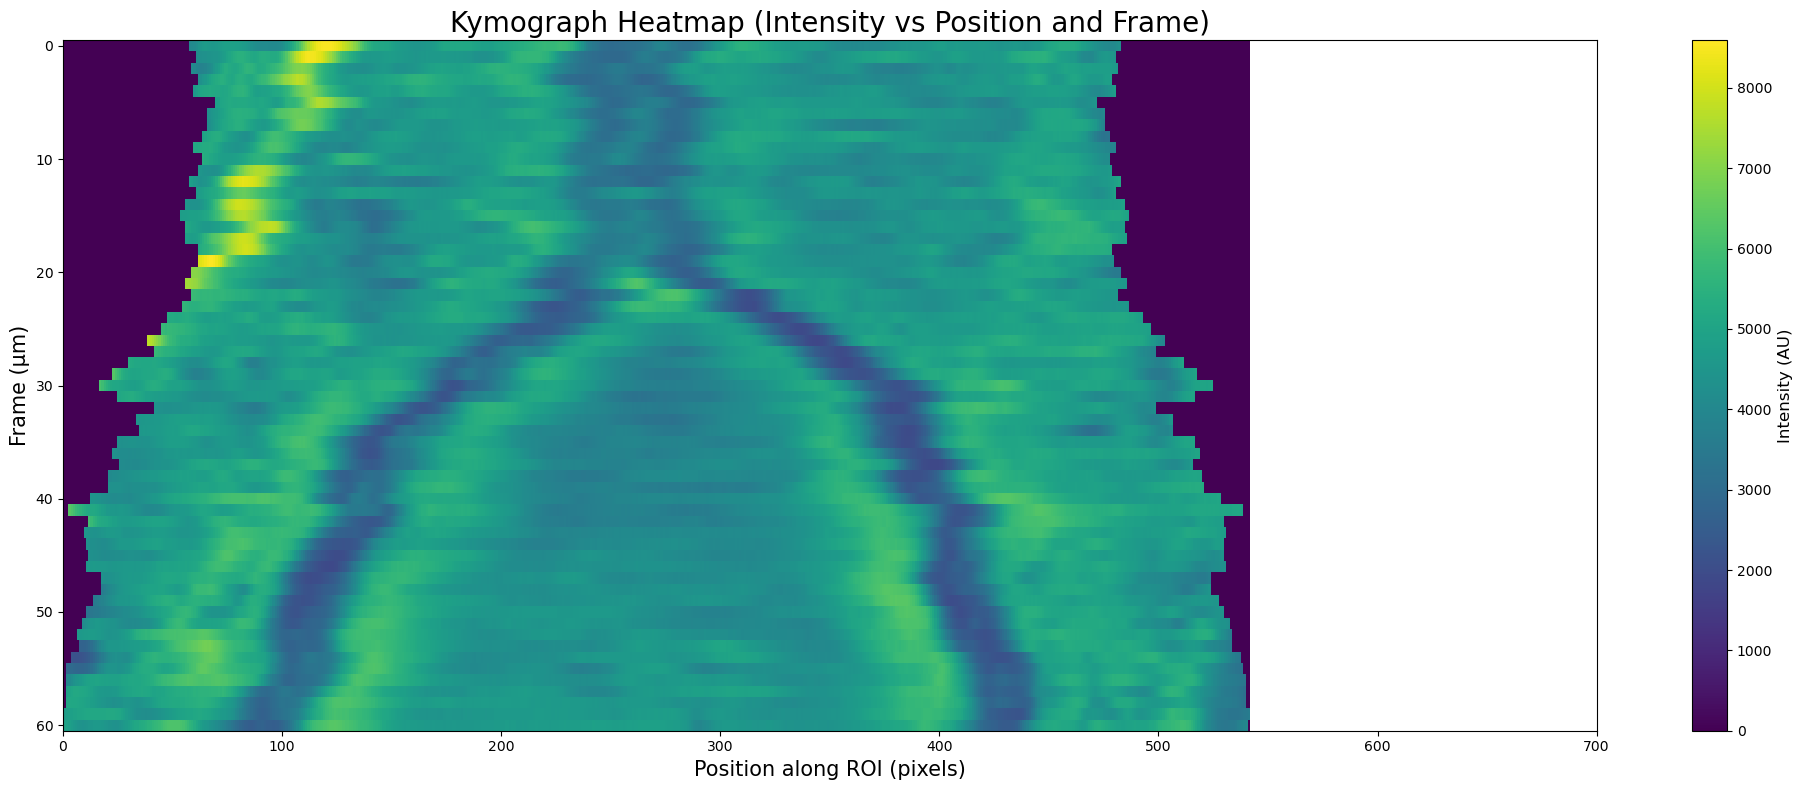

In [2]:
# extend the profile line for the kymograph on both ends
def extend_line(x1, y1, x2, y2, extension_length):
    """Extend ROI line segment with subpixel precision"""
    dx = x2 - x1
    dy = y2 - y1
    length = np.hypot(dx, dy)
    
    if length == 0:
        return x1, y1, x2, y2

    unit_vector = (dx/length, dy/length)
    return (
        x1 - unit_vector[0] * extension_length,
        y1 - unit_vector[1] * extension_length,
        x2 + unit_vector[0] * extension_length,
        y2 + unit_vector[1] * extension_length
    )

def load_image_stack(image_path):
    """Load and validate multi-page TIFF stack"""
    stack = tifffile.imread(image_path)
    if stack.ndim == 2:
        stack = np.expand_dims(stack, axis=0)
    return stack

def load_roi_coordinates(csv_path):
    """Load dynamic ROI coordinates for all frames"""
    df = pd.read_csv(csv_path)
    required_cols = {'X1', 'Y1', 'X2', 'Y2'}
    if not required_cols.issubset(df.columns):
        raise ValueError("CSV missing required coordinate columns")
    return df[['X1', 'Y1', 'X2', 'Y2']].astype(float)

def generate_padded_kymograph(stack, df_coords, extension_length=50, linewidth=5):
    """Generate kymograph with dynamic zero-padding for variable profile lengths"""
    extended_coords = [extend_line(*row, extension_length) for _, row in df_coords.iterrows()]
    
    # First pass: Calculate actual profile lengths and find maximum
    profile_lengths = []
    profiles = []
    
    for i, (x1, y1, x2, y2) in enumerate(extended_coords):
        profile = profile_line(
            stack[i],
            (y1, x1),  # skimage uses (row, col) order
            (y2, x2),
            linewidth=linewidth,
            mode='reflect'
        )
        profiles.append(profile)
        profile_lengths.append(len(profile))
    
    max_length = max(profile_lengths)
    n_frames = stack.shape[0]
    
    # Initialize kymograph with zeros (black padding)
    kymograph = np.zeros((n_frames, max_length), dtype=np.float32)
    
    # Second pass: Apply symmetric zero-padding
    for i in tqdm(range(n_frames), desc="Generating kymograph"):
        profile = profiles[i]
        pad_total = max_length - len(profile)
        
        if pad_total > 0:
            pad_left = pad_total // 2
            pad_right = pad_total - pad_left
            kymograph[i] = np.pad(profile, (pad_left, pad_right), mode='constant', constant_values=0)
        else:
            kymograph[i] = profile[:max_length]  # Truncate if longer (shouldn't occur)
    
    return kymograph, max_length

def plot_combined_profile(kymograph, heatmapplot):
    """
    Generate and save a heatmap of the kymograph showing frames on the y-axis
    and position along ROI (pixels) on the x-axis.

    Parameters:
       kymograph: 2D numpy array with shape (frames, profile_length).
       plot_out_combined: Path to save the kymograph heatmap plot.
    """
    num_frames, profile_length = kymograph.shape

    plt.figure(figsize=(20, 8))
    
    # Display the kymograph as a heatmap
    plt.imshow(kymograph, aspect='auto', cmap='viridis', interpolation='nearest')
    # plt.imshow(kymograph, aspect='auto', cmap='viridis_r', interpolation='nearest')
    
    # Set axis labels and title
    plt.xlim(0, 700)
    plt.xlabel("Position along ROI (pixels)", fontsize=15)
    plt.ylabel("Frame (µm)", fontsize=15)
    plt.title("Kymograph Heatmap (Intensity vs Position and Frame)", fontsize=20)
    
    # Add a colorbar to indicate intensity values
    cbar = plt.colorbar()
    cbar.set_label("Intensity (AU)", fontsize=12)
    
    # Save and display the heatmap
    plt.tight_layout()
    plt.savefig(heatmapplot, dpi=300)
    plt.show()

def main():
    # Configuration
    folder = r"E:\Kymograph_generation_for_3D_image"
    input_dir = os.path.join(folder, "input_folder")
    output_dir = os.path.join(folder, "output_folder")
    os.makedirs(output_dir, exist_ok=True)
    # heatmapplot = os.path.join(output_dir, "padded_kymograph_results/kymograph_heatmap.png")

    paths = {
        'image': os.path.join(input_dir, "AL001_20240607_Male meiotic spindle_Extended Depth of Focus-variance.tif"),
        'csv': os.path.join(input_dir, "tabel1.csv"),
        'kymograph': os.path.join(output_dir, "kymograph.tif"),
        'kymograph_csv': os.path.join(output_dir, "kymograph.csv"),
        'heatmapplot': os.path.join(output_dir, 'kymograph_heatmap.png')
    }

    # Parameters
    config = {
        'extension_length': 0,
        'linewidth': 10
    }

    # Data processing pipeline
    stack = load_image_stack(paths['image'])
    df_coords = load_roi_coordinates(paths['csv'])
    
    if len(df_coords) != stack.shape[0]:
        raise ValueError(f"Frame mismatch: {stack.shape[0]} images vs {len(df_coords)} coordinates")

    # Generate padded kymograph
    kymograph, max_length = generate_padded_kymograph(
        stack, df_coords,
        extension_length=config['extension_length'],
        linewidth=config['linewidth']
    )

    # Save outputs
    '''kymograph output to tif format'''
    tifffile.imwrite(paths['kymograph'], kymograph)
    print(f"Kymograph saved to {paths['kymograph']}\nMax profile length: {max_length}px")

    '''kymograph output to CSV file'''
    pd.DataFrame(
        kymograph.astype(np.float64),  # Increase precision for CSV
        columns=[f'pos_{i:04d}' for i in range(kymograph.shape[1])]
    ).to_csv(paths['kymograph_csv'], index_label='frame')
    
    plot_combined_profile(kymograph, paths['heatmapplot'])

if __name__ == "__main__":
    main()
